# COSMOS master catalogue
## Preparation of KIDS/VST data

Kilo Degree Survey/VLT Survey Telescope catalogue: the catalogue comes from `dmu0_KIDS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The aperture corrected aperture magnitude in each band (10 pixels = 2")
- The Petrosian magnitude to be used as total magnitude (no “auto” magnitude is provided).

We take 2014 as the observation year from a typical image header.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
970e176 (Mon Sep 11 16:26:40 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL  = "kids_ra"
DEC_COL = "kids_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'ID': "kids_id",
        'RAJ2000': "kids_ra",
        'DECJ2000': "kids_dec",
        'CLASS_STAR':  "kids_stellarity",
        'MAG_AUTO_U': "m_kids_u", 
        'MAGERR_AUTO_U': "merr_kids_u", 
        'MAG_AUTO_G': "m_kids_g", 
        'MAGERR_AUTO_G': "merr_kids_g", 
        'MAG_AUTO_R': "m_kids_r", 
        'MAGERR_AUTO_R': "merr_kids_r", 
        'MAG_AUTO_I': "m_kids_i", 
        'MAGERR_AUTO_I': "merr_kids_i", 
        'FLUX_APERCOR_10_U': "f_ap_kids_u",
        'FLUXERR_APERCOR_10_U': "ferr_ap_kids_u",
        'FLUX_APERCOR_10_G': "f_ap_kids_g",
        'FLUXERR_APERCOR_10_G': "ferr_ap_kids_g",
        'FLUX_APERCOR_10_R': "f_ap_kids_r",
        'FLUXERR_APERCOR_10_R': "ferr_ap_kids_r",
        'FLUX_APERCOR_10_I': "f_ap_kids_i",
        'FLUXERR_APERCOR_10_I': "ferr_ap_kids_i"

    })


catalogue = Table.read("../../dmu0/dmu0_KIDS/data/KIDS-DR3_COSMOS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2014 #A range of observation dates from 2011 to 2015.

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        #Convert fluxes in maggies to uJy
        catalogue[col] *= 3631. * 1.e6
        catalogue[col].unit = 'uJy'
        catalogue[errcol] *= 3631. * 1.e6
        catalogue[errcol].unit = 'uJy'

        mag, mag_error = flux_to_mag(np.array(catalogue[col]) * 1.e-6, 
                                     np.array(catalogue[errcol]) * 1.e-6)
        
        # Magnitudes are added
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(mag_error, name="m{}".format(errcol[1:])))
        

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,kids_id,kids_ra,kids_dec,kids_stellarity,m_kids_u,merr_kids_u,m_kids_g,merr_kids_g,m_kids_r,merr_kids_r,m_kids_i,merr_kids_i,f_ap_kids_u,ferr_ap_kids_u,f_ap_kids_g,ferr_ap_kids_g,f_ap_kids_r,ferr_ap_kids_r,f_ap_kids_i,ferr_ap_kids_i,f_kids_u,ferr_kids_u,flag_kids_u,f_kids_g,ferr_kids_g,flag_kids_g,f_kids_r,ferr_kids_r,flag_kids_r,f_kids_i,ferr_kids_i,flag_kids_i,m_ap_kids_u,merr_ap_kids_u,m_ap_kids_g,merr_ap_kids_g,m_ap_kids_r,merr_ap_kids_r,m_ap_kids_i,merr_ap_kids_i
,,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,
0,KIDS J095828.65+014133.82,149.619391921,1.69272731432,0.000349136,nan,nan,18.0889,0.0152773,17.9543,0.0129659,17.671,0.0365009,nan,nan,4.96096,0.159338,5.68287,0.128468,6.06426,0.482844,nan,nan,False,211.068,2.96993,False,238.944,2.85348,False,310.17,10.4274,False,nan,nan,22.1611,0.034872,22.0136,0.0245443,21.9431,0.0864476
1,KIDS J095935.70+014121.64,149.898770437,1.68934329445,0.875345,16.5702,0.00339415,nan,nan,nan,nan,nan,nan,803.85,1.90665,nan,nan,nan,nan,nan,nan,854.901,2.67253,False,nan,nan,False,nan,nan,False,nan,nan,False,16.6371,0.00257526,nan,nan,nan,nan,nan,nan
2,KIDS J095820.45+014108.43,149.585193525,1.68567429701,0.980973,16.114,0.00224911,nan,nan,nan,nan,nan,nan,1128.78,2.2189,nan,nan,nan,nan,nan,nan,1301.32,2.6957,False,nan,nan,False,nan,nan,False,nan,nan,False,16.2685,0.00213428,nan,nan,nan,nan,nan,nan
3,KIDS J100142.36+014057.92,150.426495282,1.68275682541,0.0286447,nan,nan,19.1848,0.012677,17.8617,0.00378535,17.3699,0.00856885,nan,nan,23.4913,0.194308,80.952,0.200246,134.952,0.598942,nan,nan,False,76.9253,0.898176,False,260.207,0.907195,False,409.303,3.2303,False,nan,nan,20.4727,0.00898068,19.1294,0.00268572,18.5746,0.0048187
4,KIDS J095951.40+014049.31,149.964174628,1.68036308921,0.0286191,19.6391,0.0725325,19.729,0.027275,17.8824,0.00482037,17.2952,0.0103867,1.31746,0.381408,9.74605,0.172779,54.0147,0.176987,103.095,0.580425,50.6248,3.38199,False,46.6008,1.17067,False,255.3,1.13346,False,438.47,4.19464,False,23.6007,0.314324,21.4279,0.0192481,19.5687,0.00355757,18.8669,0.00611267
5,KIDS J095905.47+014050.37,149.772797661,1.68065713814,0.916464,21.685,0.0833215,18.7932,0.00314916,17.4489,0.00106641,16.8772,0.00168516,8.29511,0.356619,112.042,0.313766,381.824,0.352298,673.227,0.855236,7.69145,0.590257,False,110.332,0.320016,False,380.566,0.373794,False,644.359,1.00011,False,21.6029,0.0466774,18.7766,0.00304054,17.4453,0.00100178,16.8296,0.00137927
6,KIDS J100104.26+014048.69,150.267735742,1.68019039136,0.0286743,21.8121,0.170237,19.948,0.0125162,18.5262,0.00343891,18.0241,0.00764391,2.72389,0.332897,17.5297,0.183951,69.4975,0.188674,115.923,0.593094,6.84134,1.07268,False,38.0874,0.439068,False,141.098,0.446907,False,224.061,1.57746,False,22.812,0.132692,20.7906,0.0113934,19.2951,0.00294759,18.7396,0.00555492
7,KIDS J100009.85+014044.87,150.041047372,1.67913082246,0.0286546,nan,nan,19.4247,0.0152271,18.1379,0.0044839,17.6499,0.0113336,nan,nan,17.9427,0.191037,64.9487,0.186073,105.471,0.582475,nan,nan,False,61.6757,0.86498,False,201.755,0.833211,False,316.267,3.30139,False,nan,nan,20.7653,0.0115599,19.3686,0.00311055,18.8422,0.0059961
8,KIDS J100119.37+014053.55,150.330710792,1.68154193583,0.998776,nan,nan,15.9778,0.00107028,nan,nan,nan,nan,nan,nan,1265.08,1.34586,nan,nan,nan,nan,nan,nan,False,1475.24,1.45424,False,nan,nan,False,nan,nan,False,nan,nan,16.1447,0.00115506,nan,nan,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_kids_u', 
             'merr_ap_kids_g', 
             'merr_ap_kids_r', 
             'merr_ap_kids_i']
FLAG_NAME = 'kids_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 152946 sources.
The cleaned catalogue has 152946 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

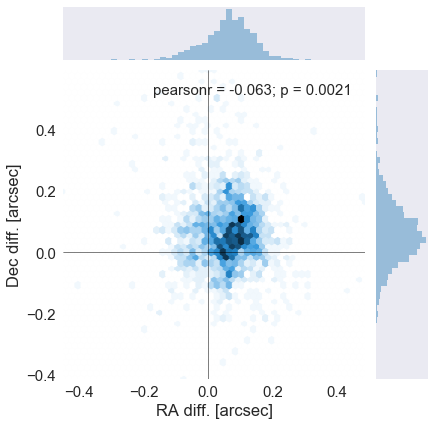

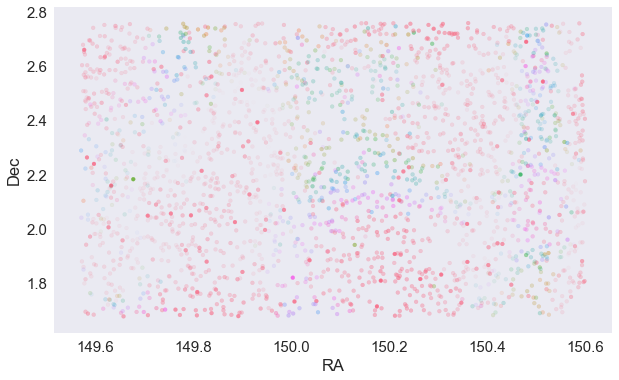

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.06793673346123796 arcsec
Dec correction: -0.05321466159404764 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

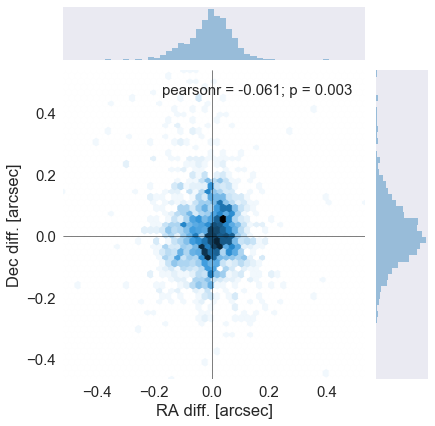

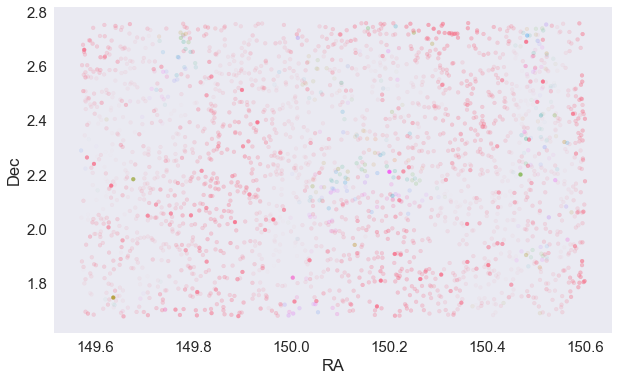

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "kids_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2633 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/KIDS.fits".format(OUT_DIR), overwrite=True)